## Programming AlphaGo Zero algorithm for Tic-Tac-Toe

### Importing required libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
# from game_backup import Game, GameState
# reload(game_ttt)
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle
import config

/home/surya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Creating game environment, memory, players and CNNs to store learning

In [2]:
env = Game()
memory = Memory(config.MEMORY_SIZE)

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

best_NN.model.set_weights(current_NN.model.get_weights())
copyfile('./config.py', run_folder + 'config.py')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [4]:
######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)

### Training process to learn playing tic-tac-toe

In [6]:
best_player_version = 0
iteration = 0

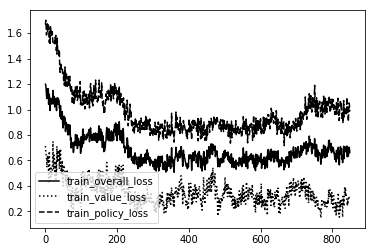




TOURNAMENT...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
SCORES
{'best_player': 0, 'drawn': 20, 'current_player': 0}

STARTING PLAYER / NON-STARTING PLAYER SCORES
{'sp': 0, 'drawn': 20, 'nsp': 0}



ITERATION NUMBER 89
BEST PLAYER VERSION 17
SELF PLAYING 20 EPISODES...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

RETRAINING...
Epoch 1/3
128/128 [==============================] - 0s 283us/step - loss: 0.7019 - value_head_loss: 0.3606 - policy_head_loss: 0.9949
Epoch 2/3
128/128 [==============================] - 0s 277us/step - loss: 0.6694 - value_head_loss: 0.3135 - policy_head_loss: 0.9771
Epoch 3/3
128/128 [==============================] - 0s 286us/step - loss: 0.6604 - value_head_loss: 0.3058 - policy_head_loss: 0.9669
Epoch 1/3
128/128 [==============================] - 0s 274us/step - loss: 0.6869 - value_head_loss: 0.2939 - policy_head_loss: 1.0319
Epoch 2/3
128/128 [==============================] - 0s 279us/step - loss: 0.6580 - value_head_loss: 0.2738 - p

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [52]:
while 1:

    iteration += 1
#     reload(lg)
    reload(config)
    
    print('ITERATION NUMBER ' + str(iteration))
    
#     lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## SELF PLAY ########
    print('SELF PLAYING ' + str(config.EPISODES) + ' EPISODES...')
    _, memory, _, _ = playMatches(best_player, best_player, config.EPISODES, lg.logger_main, turns_until_tau0 = config.TURNS_UNTIL_TAU0, memory = memory)
    print('\n')
    
    memory.clear_stmemory()
    
    if len(memory.ltmemory) >= config.MEMORY_SIZE:

        ######## RETRAINING ########
        print('RETRAINING...')
        current_player.replay(memory.ltmemory)
        print('')

        if iteration % 5 == 0:
            pickle.dump( memory, open( run_folder + "memory/memory" + str(iteration).zfill(4) + ".p", "wb" ) )

#         lg.logger_memory.info('====================')
#         lg.logger_memory.info('NEW MEMORIES')
#         lg.logger_memory.info('====================')
        
        memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))
        
        for s in memory_samp:
            current_value, current_probs, _ = current_player.get_preds(s['state'])
            best_value, best_probs, _ = best_player.get_preds(s['state'])

#             lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
#             lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
#             lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
#             lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
#             lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
#             lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
#             lg.logger_memory.info('ID: %s', s['state'].id)
#             lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

#             s['state'].render(lg.logger_memory)
            
        ######## TOURNAMENT ########
        print('TOURNAMENT...')
        scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney, turns_until_tau0 = 0, memory = None)
        print('\nSCORES')
        print(scores)
        print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
        print(sp_scores)
        #print(points)

        print('\n\n')

        if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
            best_player_version = best_player_version + 1
            best_NN.model.set_weights(current_NN.model.get_weights())
            best_NN.write(env.name, best_player_version)

    else:
        print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

## Playing against a random agent

In [65]:
gs = GameState(np.array([
    0,0,0,
    0,0,0,
    0,0,0
]), 1)
wins = 0; loses = 0;
for kk in range(0,1):
    present_state = gs

#     print(present_state.board)
    for i in range(0,9):
        print('step: ', i)
        if(present_state.playerTurn == 1):
            preds = best_player.get_preds(present_state)
#             print('AI: predictions are: ', preds)
            actionToTake = np.argmax(preds[1])
#             print('AI: actionToTake is: ', actionToTake)
        else:
            actionToTake = random.choice(present_state.allowedActions)
#             print('RandomAgent: actionToTake is: ', actionToTake)

        (present_state, value, done) = present_state.takeAction(actionToTake)

    #     print(present_state.board)
        present_state.render_2()

        if(present_state.isEndGame):
#             print('Game', kk, 'ended. Winner is player: ', -present_state.playerTurn)
            if(present_state.playerTurn==-1):
                wins = wins + 1
            else:
                loses = loses + 1
            break
            
print('wins = ', wins)
print('loses = ', loses)

step:  0
['X', '-', '-']
['-', '-', '-']
['-', '-', '-']
step:  1
['X', '-', '-']
['O', '-', '-']
['-', '-', '-']
step:  2
['X', '-', '-']
['O', 'X', '-']
['-', '-', '-']
step:  3
['X', 'O', '-']
['O', 'X', '-']
['-', '-', '-']
step:  4
['X', 'O', '-']
['O', 'X', '-']
['X', '-', '-']
step:  5
['X', 'O', '-']
['O', 'X', '-']
['X', 'O', '-']
step:  6
['X', 'O', 'X']
['O', 'X', '-']
['X', 'O', '-']
wins =  1
loses =  0


## Playing against itself

In [56]:
gs = GameState(np.array([
    0,0,0,
    0,0,0,
    0,0,0
]), 1)
present_state = gs
# print(present_state.board)
for i in range(0,9):
    print('step: ', i)
    preds = best_player.get_preds(present_state)
#     print('predictions are: ', preds)
    actionToTake = np.argmax(preds[1])
#     print('actionToTake is: ', actionToTake)
    
    (present_state, value, done) = present_state.takeAction(actionToTake)
    
#     print(present_state.board)
    present_state.render_2()
    
    if(present_state.isEndGame):
        print('=== game ended')
        break

step:  0
['X', '-', '-']
['-', '-', '-']
['-', '-', '-']
step:  1
['X', '-', '-']
['-', 'O', '-']
['-', '-', '-']
step:  2
['X', '-', '-']
['-', 'O', '-']
['X', '-', '-']
step:  3
['X', '-', '-']
['O', 'O', '-']
['X', '-', '-']
step:  4
['X', '-', '-']
['O', 'O', 'X']
['X', '-', '-']
step:  5
['X', 'O', '-']
['O', 'O', 'X']
['X', '-', '-']
step:  6
['X', 'O', '-']
['O', 'O', 'X']
['X', 'X', '-']
step:  7
['X', 'O', '-']
['O', 'O', 'X']
['X', 'X', 'O']
step:  8
['X', 'O', 'X']
['O', 'O', 'X']
['X', 'X', 'O']
=== game ended
